# Задачи
1. Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).
2. Нарисуйте график распределения показов на объявление за весь период.
3. Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?
4. Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. 
5. *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия. 
6. Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.
7. Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))
8. Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]
9. А теперь – выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

# Описание данных
**ads_data.csv** – данные взаимодействий с рекламными объявлениями

* date – дата
* time – время
* event – действие (просмотр/клик)
* platform – платформа
* ad_id – id объявления
* client_union_id – id рекламного кабинета
* campaign_union_id – id рекламной кампании
* ad_cost_type – тип оплаты
* ad_cost – цена
* has_video – есть ли видео
* target_audience_count – размер аудитории

**ads_clients_data.csv** – характеристики рекламных клиентов

* date – дата
* client_union_id – id рекламного кабинета
* community_id – id сообщества
* create_date – дата создания рекламного клиента

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

In [86]:
ads_data = pd.read_csv('/Users/pavel/Desktop/karpov/2 МОДУЛЬ PYTHON +/ads_data.csv', parse_dates = ['date', 'time'])
ads_client_data = pd.read_csv('/Users/pavel/Desktop/karpov/2 МОДУЛЬ PYTHON +/ads_clients_data.csv', parse_dates = ['date', 'create_date'])

In [87]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [88]:
ads_client_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


**Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям.**

In [89]:
count_ads = ads_data.groupby(['ad_id', 'event'], as_index = False).size()
count_ads

,ad_id,event,size
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1
...,...,...,...
1476,122013,view,156
1477,122023,view,68
1478,122031,click,1
1479,122031,view,138


In [90]:
count_ads_pivot = pd.pivot(count_ads, columns = 'event', values = 'size', index = 'ad_id').fillna(0)
count_ads_pivot

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0
...,...,...
122004,4.0,100.0
122013,0.0,156.0
122023,0.0,68.0


In [91]:
count_ads_pivot.mean().round()

event
click    113.0
view     923.0
dtype: float64

Среднее количество кликов на объявление **113**. Среднее количество показов на объявление **923**.

**Посмотрим на распределение показов объявлений!**

* По оси x – число показов
* По оси y – доля объявлений с такими показами

**Прологарифмируем число показов, а затем построим такой график, чтобы можно было понять форму распределения.

In [92]:
log_view = np.log(ads_data.query("event == 'view'").ad_id.value_counts())
log_view

ad_id
112583    12.770824
107729    12.125925
107837    10.858922
28142     10.092122
45008      9.886748
            ...    
110591     2.564949
45969      2.564949
112872     2.397895
42507      2.397895
98274      2.302585
Name: count, Length: 956, dtype: float64

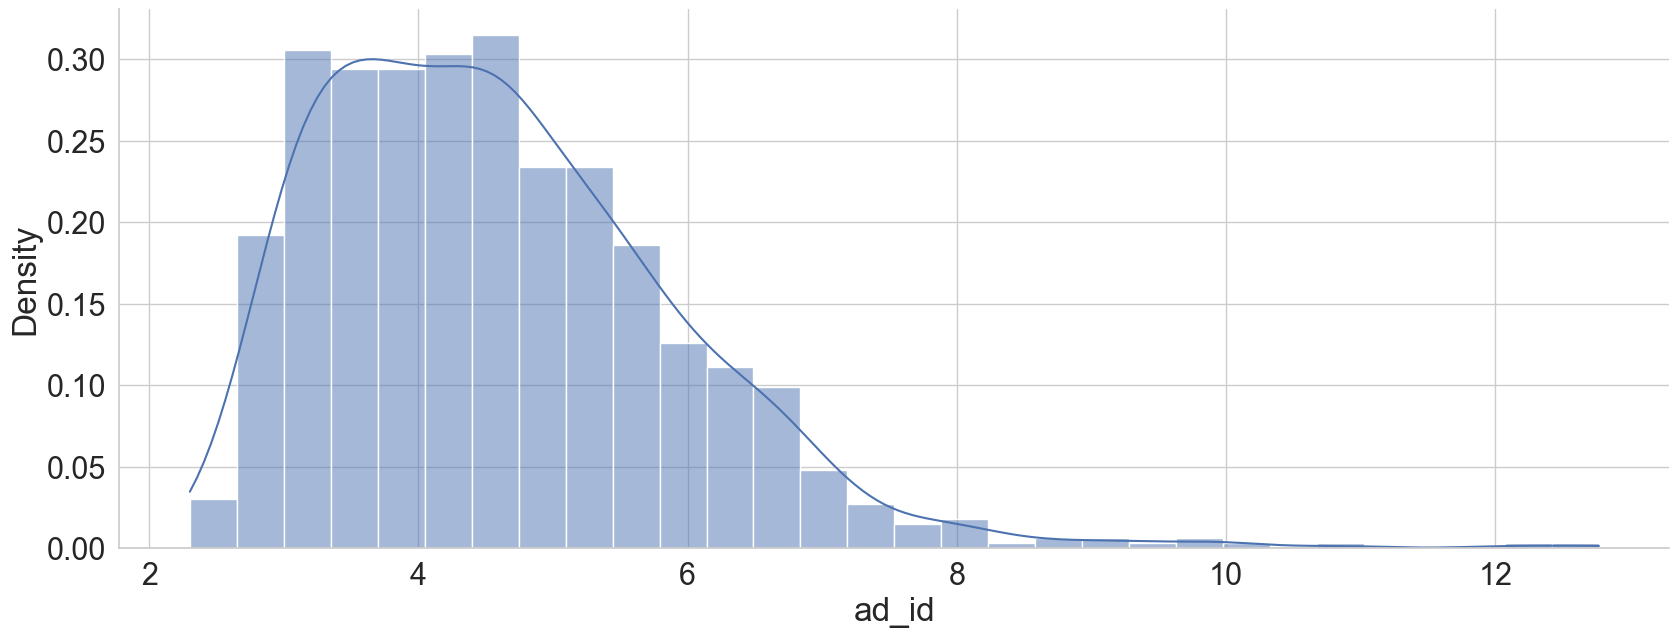

In [93]:
sns.set(
    font_scale=2,    
    style="whitegrid",    
    rc={'figure.figsize':(20,7)}    
        )
ax = sns.histplot(data = log_view, kde = True, stat = 'density')
ax.set_xlabel('ad_id')
sns.despine()

**Найдем среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитаем скользящее среднее по полученному результату с окном в 2 элемента.**

In [94]:
daily_ad_views = ads_data.query("event == 'view'").pivot_table(columns = 'date', index = 'ad_id', values = 'time', aggfunc = 'count')
daily_ad_views

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN
...,...,...,...,...,...,...
122004,85.0,15.0,NaN,NaN,NaN,NaN
122013,NaN,NaN,NaN,134.0,22.0,NaN
122023,NaN,NaN,NaN,53.0,15.0,NaN


In [95]:
daily_ad_views_mean = daily_ad_views.mean().round()
daily_ad_views_mean

date
2019-04-01    154.0
2019-04-02    138.0
2019-04-03    164.0
2019-04-04    676.0
2019-04-05    919.0
2019-04-06    277.0
dtype: float64

In [96]:
daily_ad_views_rolling = daily_ad_views.mean().rolling(window = 2).mean().round()
daily_ad_views_rolling

date
2019-04-01      NaN
2019-04-02    146.0
2019-04-03    151.0
2019-04-04    420.0
2019-04-05    798.0
2019-04-06    598.0
dtype: float64

Ответ: `598`

**Скользящее среднее часто используется для поиска аномалий в данных. Попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).**

**Посчитаем в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?**

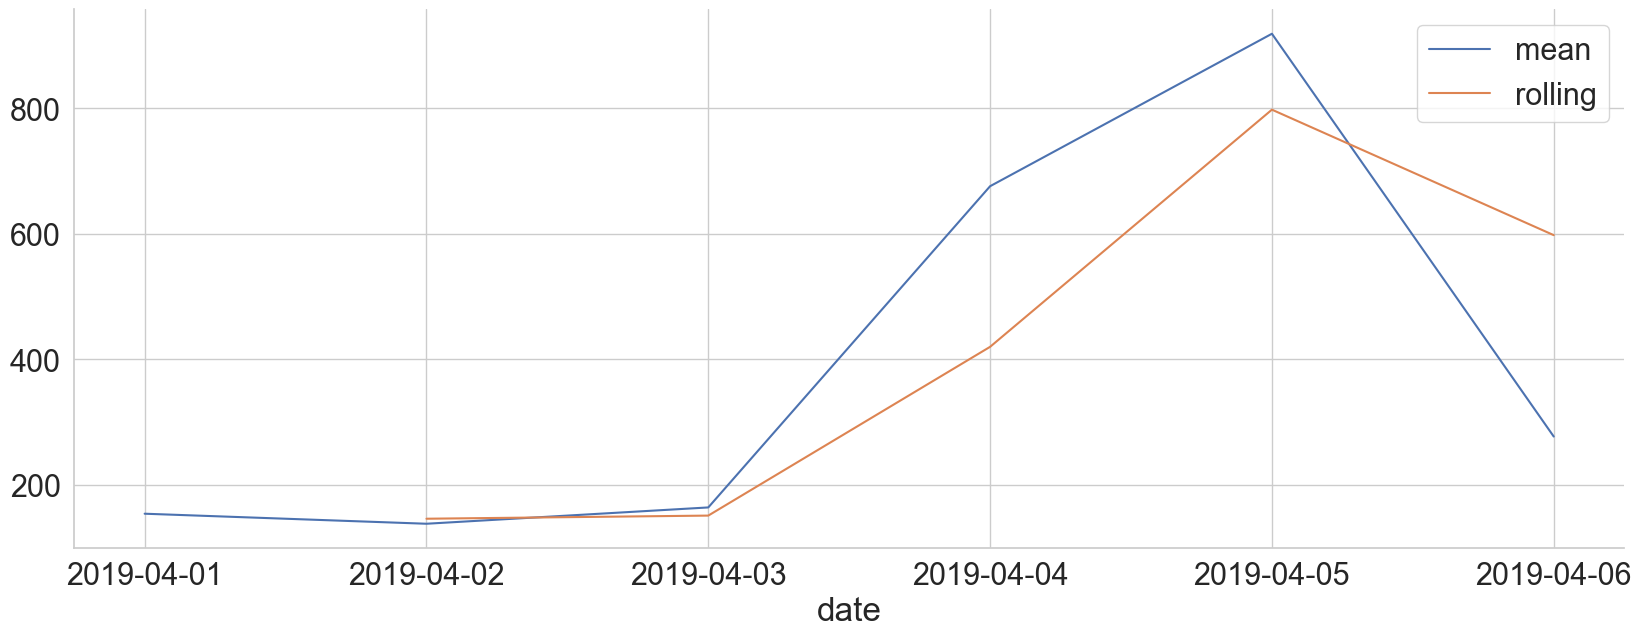

In [97]:
ax = sns.lineplot(data = daily_ad_views_mean, label = 'mean')
ax = sns.lineplot(data = daily_ad_views_rolling, label = 'rolling')
plt.legend()
sns.despine()

In [98]:
np.abs(daily_ad_views_rolling - daily_ad_views_mean).idxmax()

Timestamp('2019-04-06 00:00:00')

**Объединим данные рекламы с данными о рекламных клиентах и найдем среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).**

In [99]:
merged = pd.merge(ads_data, ads_client_data, on = 'client_union_id', suffixes = ('_ad_data', '_client_data'))
merged.head()

,date_ad_data,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_client_data,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04


In [172]:
merged['diffrence'] = merged.date_ad_data - merged.create_date
first_ad = merged.groupby('client_union_id').diffrence.min()
first_ad.head()

client_union_id
1     98 days
9    114 days
13    66 days
16   105 days
20    32 days
Name: diffrence, dtype: timedelta64[ns]

In [173]:
first_ad.mean().days

124

Ответ: `124`

**Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.**

In [174]:
lt_365 = first_ad.loc[diffrence < pd.Timedelta(365, unit='day')]
lt_365

client_union_id
1         98 days
9        114 days
13        66 days
16       105 days
20        32 days
           ...   
122004    67 days
122013   151 days
122023   126 days
122031    96 days
122078    71 days
Name: diffrence, Length: 838, dtype: timedelta64[ns]

In [175]:
round(len(lt_365) / ads_client_data.client_union_id.nunique() * 100,2)

0.69

**Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.**

**Определим, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).**

In [176]:
bins = [0,30,90,180,365]
bins = [pd.Timedelta(bin, 'd') for bin in bins]
labels = ['0 - 30', '30 - 90', '90 - 180', '180 - 365']
bins

[Timedelta('0 days 00:00:00'),
 Timedelta('30 days 00:00:00'),
 Timedelta('90 days 00:00:00'),
 Timedelta('180 days 00:00:00'),
 Timedelta('365 days 00:00:00')]

In [190]:
binned_first = pd.cut(first_ad, bins, labels=labels).reset_index()
binned_first.head()

,client_union_id,diffrence
0,1,90 - 180
1,9,90 - 180
2,13,30 - 90
3,16,90 - 180
4,20,30 - 90


In [201]:
binned_first_count = binned_first.diffrence.value_counts().reset_index()
binned_first_count

,diffrence,count
0,90 - 180,396
1,30 - 90,263
2,180 - 365,168
3,0 - 30,11


**Построим барплот, на котором будут показаны категории с количеством уникальных клиентов в них. Расположим их так, чтобы внизу была самая малочисленная, а наверху – самая большая.**

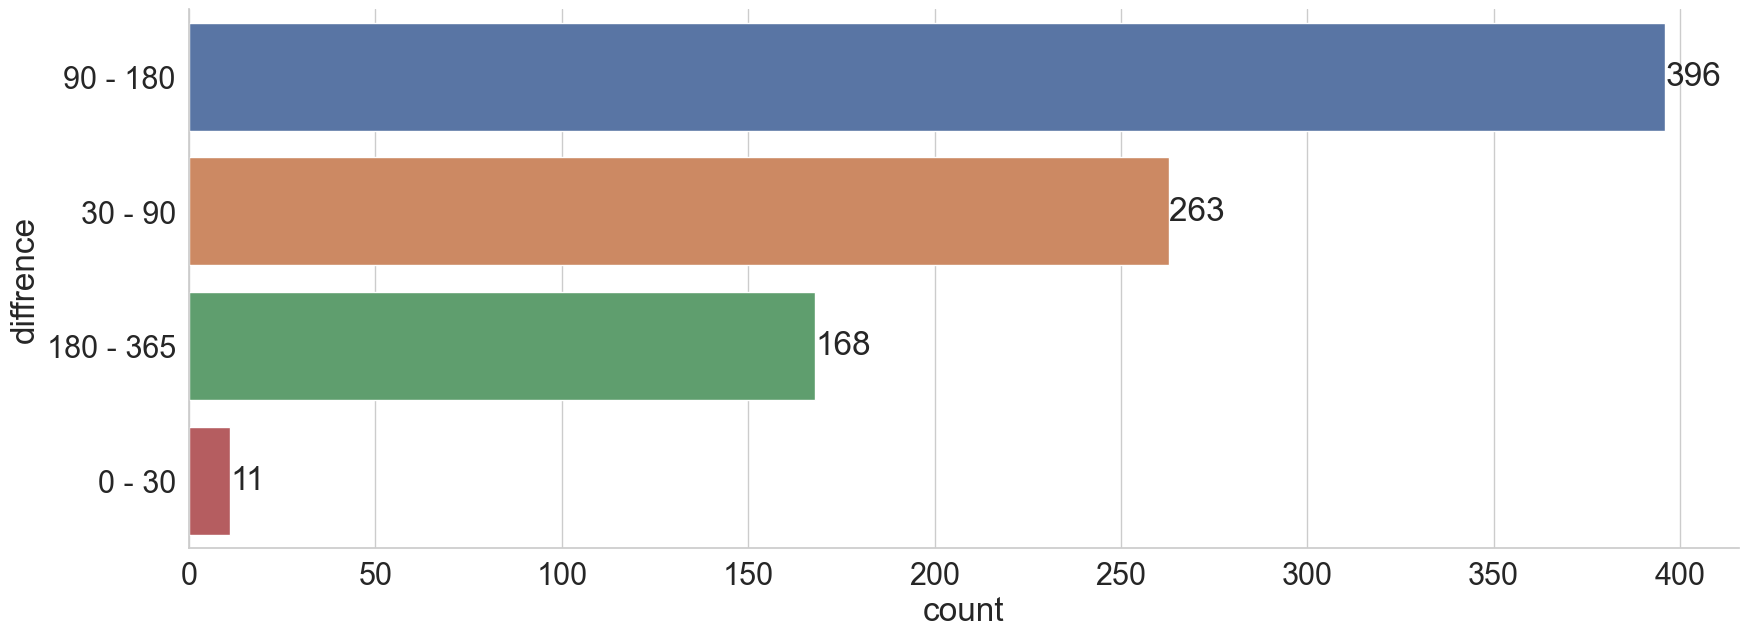

In [210]:
ax = sns.barplot(data = binned_first_count, y = 'diffrence', x = 'count', \
            orient = 'h', order = binned_first_count.diffrence)
ax.bar_label(ax.containers[0])
sns.despine()

1. **от 90 до 180**
2. **от 30 до 90**
3. **от 180 до 365**
4. **от 0 до 30**